In [1]:
import re
import jieba
import nltk
nltk.download('words')
eng_words = set(nltk.corpus.words.words())
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from urllib.parse import unquote
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


0. [x] 加入標題、url 的文字，針對這兩種地方出現的字詞加重頻率
1. 重新清理文本 (NLTK)
2. 測試其他分詞方法
    - [x] jieba
    - [x] CKIP: 降至2維的分布和 jieba 貌似相差不大


3. 測試其他字詞重要度算法
    - [x] TF-IDF (current)
    (精準地說是 測試其他 word-embedding 算法) 但要可以用文章向量回找相似詞的
    - [x] Word2Vec
    - BERT
    - Transformer
    - FastText
    - ----
    - Doc2Vec
    - Glove
    - ELMO
    - GPT


4. 生成相關關鍵字與近似關鍵字的邏輯
    
5. 找出能夠區隔排名分群的feature


In [2]:
search_keyword = 'seo 公司'
num = 50

####設定停用詞
# cn_stopwords = pd.read_csv('cn_stopwords.csv')['$'].values.tolist()
# 更完整的停用詞庫: https://github.com/tomlinNTUB/Machine-Learning/blob/master/data/%E5%81%9C%E7%94%A8%E8%A9%9E-%E7%B9%81%E9%AB%94%E4%B8%AD%E6%96%87.txt
file = open('cn_stopwords.txt', 'r', encoding='utf-8')
try:
    content = file.read()
    cn_stopwords = content.split('\n')
finally:
    file.close()
    
exclude_cn_marks = ['〈', '〉','＜','＞','《','》','｛','｝','﹛','﹜','［','］','「','」','『','』','【','】','〔','〕','。','，','；','：','»','｜','！','？','–']
for char in exclude_cn_marks:
    cn_stopwords.append(char)

file = open('eng_stopwords.txt', 'r')
try:
    content = file.read()
    eng_stopwords = content.split(',')
finally:
    file.close()

# https://blog.csdn.net/linshenwei1995/article/details/78987444
exclude_marks = ['/','\\','>','<','»','->','!','@','#','$','^','&','*','(',')','-','=','+','{','}','[',']','|',';',':','.','..','...',',','?','~','`',"'",'\n','\r\n']
for char in exclude_marks:
    eng_stopwords.append(char)

all_stopwords = list()
for char in cn_stopwords:
    all_stopwords.append(char)
for char in eng_stopwords:
    all_stopwords.append(char)
    
all_marks = exclude_cn_marks + exclude_marks

####啟動 tf-idf 計算函式
vectorizer = TfidfVectorizer(analyzer='word', stop_words=all_stopwords)#, max_df=1.0, min_df=0.2)


In [36]:
####設定CKIP建議辭典

dictionary = construct_dictionary({
    '達米肉鋪': 1, '部落格': 1, 'harris先生': 1, 'harris 先生': 1, '台北數位集團': 1, 'pineapple web': 1, 'optimization': 1,
    '玩構網路': 1, '人力銀行': 1, '創藝網際': 1, '亞文營銷': 1, '股份有限公司': 1, '環球暢貨': 1, '馬路科技': 1, '獨角獸工坊': 1,
    '揚京快客': 1, 'tenten': 1, '接案': 1, '低調': 1, '各式各樣': 1, 'hong kong': 1, 'search': 2, 'google': 2, 'yahoo': 2, '改善': 2, 
    '官網': 2, '優化': 2
})

print(dictionary)

[(2, {'接案': 1.0, '低調': 1.0, '改善': 2.0, '官網': 2.0, '優化': 2.0}), (3, {'部落格': 1.0}), (4, {'達米肉鋪': 1.0, '玩構網路': 1.0, '人力銀行': 1.0, '創藝網際': 1.0, '亞文營銷': 1.0, '環球暢貨': 1.0, '馬路科技': 1.0, '揚京快客': 1.0, '各式各樣': 1.0}), (5, {'獨角獸工坊': 1.0, 'yahoo': 2.0}), (6, {'台北數位集團': 1.0, '股份有限公司': 1.0, 'tenten': 1.0, 'search': 2.0, 'google': 2.0}), (8, {'harris先生': 1.0}), (9, {'harris 先生': 1.0, 'hong kong': 1.0}), (12, {'optimization': 1.0}), (13, {'pineapple web': 1.0})]


In [4]:
def sub_marks(x):
    text_list = list(x)
    new_list = list()
    for char in text_list:
        if char not in all_marks:
            new_list.append(char)
    return ''.join(new_list)

page_data = pd.read_csv('SERP_{}_num_{}.csv'.format(search_keyword, num))
df = pd.read_csv('{}_{}_articles_features.csv'.format(search_keyword, num))
df = pd.concat([df.iloc[:, np.r_[0, 2:7]], page_data.iloc[:, :2]], axis=1)
df['link'] = df['link'].apply(lambda x: unquote(x).lower())
df['article_content'] = df['article_content'].apply(lambda x: sub_marks(x.lower()))
df['title'] = df['title'].apply(lambda x: sub_marks(x.lower()))
df['desc'] = df['desc'].apply(lambda x: sub_marks(x.lower()))
df['web_content_feature'] = df['article_content']+' '+(df['link']+' ')*30+' '+(df['title']+' ')*20+' '+(df['desc']+' ')*2

print(df.shape)
df.head(1)


(50, 9)


,link,article_keywords,article_content,article_published_time,article_modified_time,article_schema,title,desc,web_content_feature
0,https://www.da-vinci.com.tw/tw/blog/seo-cost,NaN,搜尋 搜尋 f tw tw cn 首頁 關於我們 公司介紹 專業團隊 服務項目 網頁設計 網...,NaN,NaN,NaN,seo收費行情該怎麼選擇seo公司seo優化部落格達文西,2020年3月17日 大家都在討論seo關鍵字排名市場報價非常紊亂比網頁設計更沒有報價依據...,搜尋 搜尋 f tw tw cn 首頁 關於我們 公司介紹 專業團隊 服務項目 網頁設計 網...


#### 文本清理
- lowercase
- remove
    - punctuation
    - tags
    - special characters & digits
- stemming
- lemmatizing
    

In [264]:
def clean_text(article):
    
    # 过滤不了\\ \ 中文（）还有————
    r1 = u'[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'#用户也可以在此进行自定义过滤字符 
    # 者中规则也过滤不完全
    r2 = "[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+"
    # \\\可以过滤掉反向单杠和双杠，/可以过滤掉正向单杠和双杠，第一个中括号里放的是英文符号，第二个中括号里放的是中文符号，第二个中括号前不能少|，否则过滤不完全
    r3 =  "[.!//_,$&%^*()<>+\"'?@#-|:~{}]+|[——！\\\\，。=？、：“”‘’《》【】￥……（）]+" 
    # 去掉括号和括号内的所有内容
    r4 =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*()<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"
#     rule_clean_tag = re.compile('<.*?>')
    ## 會把中文字都過濾掉，現在還在找原因..
#     clean_text = re.sub(rule_clean_tag, ' ', str(article))  # remove html tag
    clean_text = str(article)
#     clean_text = re.sub(r1, '', clean_text)
#     clean_text = re.sub(r2, '', clean_text)
    clean_text = re.sub(r3, '', clean_text)
#     clean_text = re.sub(r4, '', clean_text)
    
    return clean_text

df['web_content_feature'] = df['web_content_feature'].apply(lambda x: clean_text(x))
df['article_content'] = df['article_content'].apply(lambda x: clean_text(x))


#### Jieba 分詞

In [32]:
def check_engwords_valid(x):
    if len(re.findall(r'[\u4e00-\u9fff]+', x)) == 0:
        bool_value = x.lower() in eng_words or not x.isalpha()
    else:
        bool_value = True
    return bool_value

# isdigit() : https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number 
df['web_content_cutword'] = df['desc'].apply(lambda x: [x.strip() for x in jieba.cut(x, cut_all=False) if ((x.strip() != ' ') and (len(x.strip()) >1) and (x.strip() != '') and (x.strip() not in all_stopwords) and (any(char.isdigit() for char in x.strip()) == False))])
df['web_content_cutword'].values[0]



['討論',
 'seo',
 '關鍵',
 '排名',
 '市場',
 '報價',
 '紊亂',
 '網頁',
 '設計',
 '報價',
 '依據',
 'seo',
 '完全',
 '無法',
 '辨識',
 'seo',
 '公司',
 '好不好',
 '每個',
 'seo']

#### 中研院 CKIP 分詞系統
- 分詞後將 list 另存一欄
- 新增自訂辭典
- https://github.com/ckiplab/ckiptagger/wiki/Chinese-README

In [52]:
# data_utils.download_data_gdown('./')  # https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
ws = WS("./data", disable_cuda=False)
# pos = POS("./data", disable_cuda=False)
# ner = NER("./data", disable_cuda=False)

df['web_content_cutword'] = df['link'].apply(lambda x: [x.strip() for x in ws([x], 
                                                                                          sentence_segmentation=True, 
                                                                                          segment_delimiter_set={",", "。", ":", "?", "!", ";"," ", "/","."}, 
                                                                                          coerce_dictionary=dictionary)[0] if ((x.strip() != ' ') and (len(x.strip()) >1) and (x.strip() != '') and (x.strip() not in all_stopwords) and (any(char.isdigit() for char in x.strip()) == False))])
df['web_content_cutword'].values


array([list(['https', 'da-vinci', 'tw/', 'tw/', 'blog/', 'seo-cost']),
       list(['https', 'inboundmarketing', 'tw/', 'seo/', 'seo', '公司', '推薦', 'html']),
       list(['https', 'yesharris', 'com/', 'before-seo-agency/']),
       list(['https', 'growthmarketing', 'tw/', 'seo', '優化', '公司']),
       list(['https', 'ranking', 'works/', 'seo', '教學', 'seo', '公司']),
       list(['https', 'corners', 'tw/']),
       list(['https', 'seo', 'tenten', 'co/']),
       list(['https', 'airnet', 'tw/', 'seo', '公司']),
       list(['https', 'seo', 'whoops', 'tw/']),
       list(['https', 'seookay', 'com/']),
       list(['https', 'awoo', 'tw/', 'blog/', 'seo-company/']),
       list(['https', 'awoo', 'tw/']),
       list(['https', 'taipeiads', 'com/', 'seo', 'php']),
       list(['https', 'leononline', 'tw/']),
       list(['https', 'sharktech', 'tw/']),
       list(['https', 'pineapple-web', 'com/', 'tw/', 'seo-agency/']),
       list(['https', 'seoseo', 'tw/']),
       list(['https', 'seoseo', 'tw/',

In [ ]:
# word_sentence_list = ws(
#     df.web_content_feature.values.tolist()[:5]
#     # sentence_segmentation = True, # To consider delimiters
#     # segment_delimiter_set = {",", "。", ":", "?", "!", ";"}), # This is the defualt set of delimiters
#     # recommend_dictionary = dictionary1, # words in this dictionary are encouraged
#     # coerce_dictionary = dictionary2, # words in this dictionary are forced
# )
# pos_sentence_list = pos(word_sentence_list)
# entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

# del ws
# del pos
# del ner

# def print_word_pos_sentence(word_sentence, pos_sentence):
#     assert len(word_sentence) == len(pos_sentence)
#     for word, pos in zip(word_sentence, pos_sentence):
#         print(f"{word}({pos})", end="\u3000")
#     print()
#     return

# for i, sentence in enumerate(df.web_content_feature.values.tolist()[:5]):
#     print()
# #     print(f"'{sentence}'")
#     print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
#     for entity in sorted(entity_sentence_list[i]):
#         print(entity)




In [53]:
sentence_list = list()
for item_list in tqdm(df.web_content_cutword.values):
    new_item_list = list()
    for item in item_list:
        if item not in all_stopwords:
            new_item_list.append(item)
    sentence_list.append(new_item_list)
    
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6649.39it/s]


#### Apply TF-IDF
統計方法，用以評估一字詞對於一個檔案集或一個語料庫中的其中一份檔案的重要程度


In [54]:
article_transform = vectorizer.fit_transform([' '.join(term_list) for term_list in sentence_list])
print(article_transform.shape)
print(vectorizer.get_feature_names())


(50, 110)
['agency', 'airnet', 'aloha', 'answer', 'appleseo', 'appseoweb', 'articles', 'asiapacdigital', 'asp', 'aun', 'awoo', 'blog', 'bnext', 'category', 'cheating', 'choose', 'cht', 'companies', 'company', 'considerations', 'corners', 'cost', 'creartive', 'creative', 'expert', 'faq', 'firstpage', 'google', 'growthmarketing', 'guide', 'hant', 'hdcourse', 'hk', 'hl', 'htm', 'html', 'https', 'hububble', 'ibest', 'ieo', 'inboundmarketing', 'internet_marketing', 'iwangoweb', 'iware', 'job', 'jobs', 'keyword', 'leftmoon', 'leononline', 'locale', 'lp', 'market', 'medium', 'meethub', 'net', 'news', 'newscan', 'nss', 'ozchamp', 'php', 'pineapple', 'polaris', 'price', 'ranking', 'ready', 'ringoli', 'seo', 'seookay', 'seoseo', 'service', 'sharktech', 'shtml', 'support', 'taipeiads', 'taiwan', 'teng', 'tenten', 'tw', 'unicornws', 'vinci', 'web', 'webmasters', 'whoops', 'works', 'yesharris', 'ykqk', 'yourator', 'zh', '優化', '公司', '台灣', '告訴', '必知', '排名', '推薦', '揭發', '搜尋', '操作', '收費', '效益', '教學', '

In [55]:
for i in range(0, 11):
    pd.DataFrame({
        'terms': vectorizer.get_feature_names(),
        'tf-idf score': article_transform.toarray()[i]
    }).sort_values('tf-idf score', ascending=False)[:10]
    

,terms,tf-idf score
79,vinci,0.546294
21,cost,0.546294
11,blog,0.456959
77,tw,0.377909
66,seo,0.181141
36,https,0.136697
0,agency,0.000000
72,support,0.000000
81,webmasters,0.000000
80,web,0.000000


,terms,tf-idf score
40,inboundmarketing,0.536391
94,推薦,0.536391
35,html,0.377858
66,seo,0.355714
89,公司,0.320661
77,tw,0.185529
36,https,0.134219
0,agency,0.000000
72,support,0.000000
79,vinci,0.000000


,terms,tf-idf score
84,yesharris,0.708811
0,agency,0.641008
66,seo,0.235028
36,https,0.177363
71,shtml,0.000000
80,web,0.000000
79,vinci,0.000000
78,unicornws,0.000000
77,tw,0.000000
76,tenten,0.000000


,terms,tf-idf score
28,growthmarketing,0.636619
88,優化,0.575721
89,公司,0.380578
77,tw,0.220196
66,seo,0.211091
36,https,0.159298
71,shtml,0.000000
80,web,0.000000
79,vinci,0.000000
78,unicornws,0.000000


,terms,tf-idf score
83,works,0.509001
63,ranking,0.509001
100,教學,0.509001
66,seo,0.337550
89,公司,0.304287
36,https,0.127365
71,shtml,0.000000
79,vinci,0.000000
78,unicornws,0.000000
77,tw,0.000000


,terms,tf-idf score
20,corners,0.919699
77,tw,0.318109
36,https,0.230132
0,agency,0.000000
82,whoops,0.000000
80,web,0.000000
79,vinci,0.000000
78,unicornws,0.000000
76,tenten,0.000000
75,teng,0.000000


,terms,tf-idf score
76,tenten,0.923491
66,seo,0.306212
36,https,0.231081
0,agency,0.000000
70,sharktech,0.000000
80,web,0.000000
79,vinci,0.000000
78,unicornws,0.000000
77,tw,0.000000
75,teng,0.000000


,terms,tf-idf score
1,airnet,0.778600
89,公司,0.465456
77,tw,0.269305
66,seo,0.258169
36,https,0.194825
70,sharktech,0.000000
79,vinci,0.000000
78,unicornws,0.000000
76,tenten,0.000000
75,teng,0.000000


,terms,tf-idf score
82,whoops,0.879703
77,tw,0.304275
66,seo,0.291693
36,https,0.220124
0,agency,0.000000
71,shtml,0.000000
80,web,0.000000
79,vinci,0.000000
78,unicornws,0.000000
76,tenten,0.000000


,terms,tf-idf score
67,seookay,0.970091
36,https,0.242741
0,agency,0.000000
70,sharktech,0.000000
80,web,0.000000
79,vinci,0.000000
78,unicornws,0.000000
77,tw,0.000000
76,tenten,0.000000
75,teng,0.000000


,terms,tf-idf score
10,awoo,0.557901
18,company,0.557901
11,blog,0.516031
77,tw,0.213381
66,seo,0.204557
36,https,0.154368
0,agency,0.000000
72,support,0.000000
81,webmasters,0.000000
80,web,0.000000


#### Average of Word2Vec vectors with TF-IDF
分詞 > TFIDF > TFIDF * word2vec

https://stackoverflow.com/questions/29760935/how-to-get-vector-for-a-sentence-from-the-word2vec-of-tokens-in-sentence


In [44]:
model = Word2Vec(sentence_list, size=100, window=5, min_count=1, workers=4)
model.save("test-w2v.model")


In [45]:
article_transform = vectorizer.fit_transform([' '.join(term_list) for term_list in sentence_list])


In [46]:
avg_article_vector = list()

for i in tqdm(range(0, len(df))):
    
    dict_term_tfidf = dict(zip(vectorizer.get_feature_names(), article_transform.toarray()[i]))
    base_vector = np.array([0.0]*100)
    valid_count = 0
    for char in df.web_content_cutword.values[i]:
        if char not in all_stopwords:
            try:
                vector = model.wv[char] * dict_term_tfidf[char]
            except:
                print(f'word {char} not in vocabulary.')
            else:
                base_vector += vector
                valid_count += 1
        else:
            print(f'{char} is in stopword lists.')
    
    print(valid_count)
    base_vector = base_vector / valid_count
    avg_article_vector.append(base_vector)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 767.19it/s]

19
20
21
21
19
23
19
18
26
29
20
32
26
29
24
word pineapple web not in vocabulary.
19
41
20
28
22
24
22
27
21
20
16
19
20
17
20
25
21
23
24
22
26
22
29
22
21
8
19
17
22
14
33
16
22
32
word hong kong not in vocabulary.
18


In [47]:
np.array(avg_article_vector).shape


(50, 100)

,index,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,principal component 21,principal component 22,principal component 23,principal component 24,principal component 25,principal component 26,principal component 27,principal component 28,principal component 29,principal component 30,principal component 31,principal component 32,principal component 33,principal component 34,principal component 35,principal component 36,principal component 37,principal component 38,principal component 39,principal component 40,principal component 41,principal component 42,principal component 43,principal component 44,principal component 45,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50
0,0,0.049099,0.040060,0.323098,0.217005,0.154247,0.058481,-0.164785,-0.008092,0.069969,-0.055467,0.031341,0.067528,-0.012883,0.448178,0.006425,0.061760,-0.002589,7.061229e-18,9.842620e-18,0.096969,-0.018974,-0.009959,0.006741,-0.028905,1.454147e-18,2.189400e-17,-1.657881e-18,0.000741,0.017675,0.089542,-0.004726,-2.666926e-17,0.143960,0.038141,0.190422,0.166961,-0.187188,0.416345,0.253104,0.039417,-0.008467,-0.068122,-0.085200,0.053314,-0.044081,-0.059312,-0.084271,0.001036,0.005976,9.845763e-17
1,1,-0.132975,0.362656,0.008442,-0.259810,-0.041699,-0.059699,-0.187993,-0.077082,-0.006687,0.126440,0.035499,0.061269,0.114256,0.014854,-0.060217,-0.117276,0.016931,3.663192e-16,-3.379408e-16,-0.010156,0.018005,0.062755,-0.010699,-0.042539,1.799336e-16,-3.687546e-16,-1.373791e-15,0.050142,-0.029094,0.005254,0.014877,-5.173208e-16,0.026526,0.036474,0.230158,-0.107205,0.094020,-0.008138,-0.163798,0.497803,-0.184030,0.229477,-0.083505,0.083107,-0.051636,-0.048873,-0.001780,0.010937,-0.030449,9.845763e-17
2,2,-0.141676,-0.074130,-0.036923,0.154638,-0.164277,-0.155380,0.367957,-0.333177,0.132084,0.322749,0.090857,0.054969,-0.320561,0.063045,0.071998,-0.219167,-0.113630,-1.949768e-15,-3.916927e-16,-0.013760,0.005181,-0.000199,-0.000939,-0.027168,-4.897051e-16,5.846902e-16,-2.156961e-15,0.005797,-0.027880,-0.000550,0.008973,-1.606758e-15,-0.027353,-0.009322,-0.107069,-0.142358,0.313987,0.321440,-0.034919,-0.038240,0.007158,0.033321,0.036177,-0.038926,0.116219,-0.107767,0.001535,-0.002738,0.000294,9.845763e-17
3,3,-0.185992,0.089818,0.046515,-0.286847,0.304481,-0.021300,0.077619,0.129279,-0.012442,0.054850,0.252429,-0.021363,-0.016052,0.020548,-0.193286,-0.067865,0.041943,-1.861815e-15,-1.021121e-15,-0.005725,-0.003455,-0.336970,0.039148,0.070213,-1.225540e-15,-1.081631e-15,4.361882e-16,-0.043309,-0.023866,-0.005701,0.001608,1.012903e-15,0.006016,0.007397,0.061650,-0.040431,0.049551,-0.030543,0.029339,0.111441,0.574794,-0.024660,0.028733,0.008833,-0.010084,-0.012169,0.010919,0.012786,0.003093,9.845763e-17
4,4,-0.332198,0.025218,-0.062830,-0.177294,0.113323,-0.061538,-0.042780,-0.050558,0.112376,-0.053276,-0.043401,-0.006764,-0.005588,-0.023164,-0.128231,-0.197135,0.083742,4.215069e-16,-6.579464e-16,-0.031114,0.044653,0.201150,-0.069076,-0.094858,-1.093510e-15,1.925464e-15,-4.224518e-15,0.134593,-0.205359,-0.520360,-0.389746,-3.593176e-16,0.062542,-0.043845,-0.138145,0.176288,-0.155747,0.072821,-0.027587,-0.059176,0.013778,0.029461,0.055123,0.033017,-0.013166,-0.013878,0.000832,0.008465,0.000438,9.845763e-17


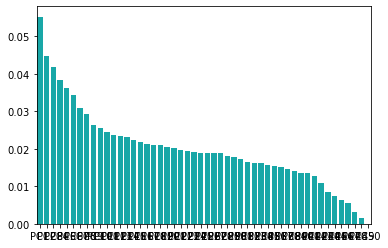

In [56]:
pca = PCA(n_components=50)
article_transform_PCA = pca.fit_transform(article_transform.toarray())  # csr_matrix.toarray() https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
# article_transform_PCA = pca.fit_transform(np.array(avg_article_vector))
sns.barplot(x=['PC' + str(x) for x in range(1, 51)], y=pca.explained_variance_ratio_, color='c')
principalDf = pd.DataFrame(data = article_transform_PCA, columns = ['principal component ' + str(x) for x in range(1, 51)])
principalDf = principalDf.reset_index()
principalDf.head()


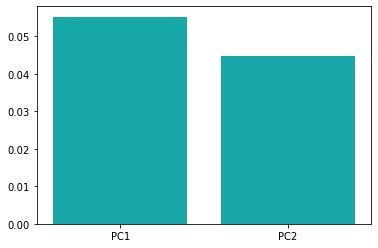

In [57]:
pca = PCA(n_components=2)
principalDf_PCA = pca.fit_transform(principalDf.iloc[:,1:].values)  # csr_matrix.toarray() https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
sns.barplot(x=['PC' + str(x) for x in range(1, 3)], y=pca.explained_variance_ratio_, color='c')
# principalDf = pd.DataFrame(data = principalDf_PCA, columns = ['principal component ' + str(x) for x in range(1, 3)])
# principalDf = principalDf.reset_index()
# principalDf.head()


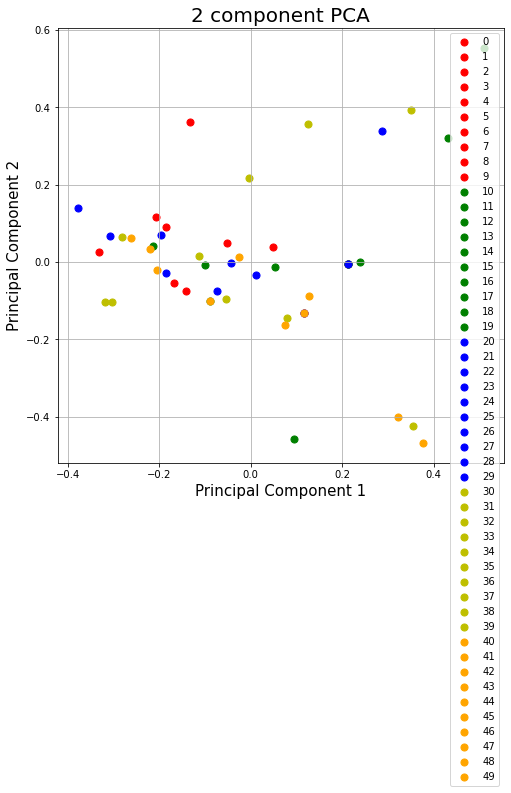

In [58]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = principalDf['index'].values
colors = ['r']*10+['g']*10+['b']*10+['y']*10+['orange']*10
for target, color in zip(targets, colors):
    indicesToKeep = principalDf['index'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'], 
               principalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid();

# add semicolon at the finish line to ignore output description


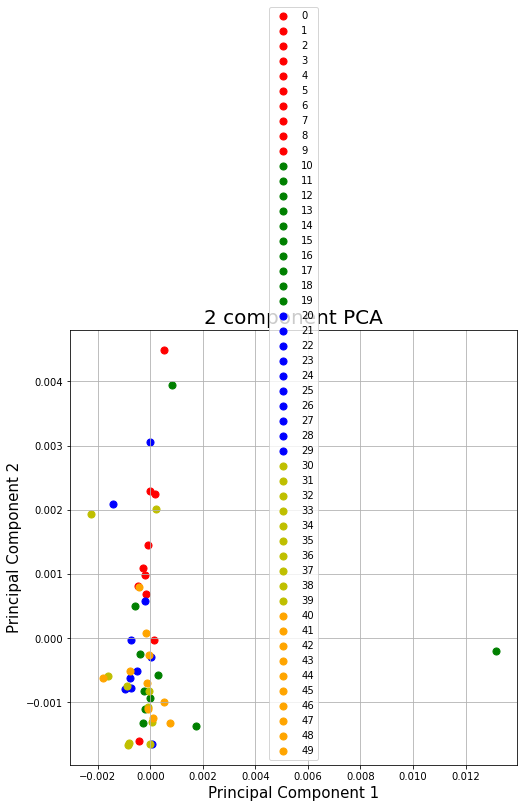

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = principalDf['index'].values
colors = ['r']*10+['g']*10+['b']*10+['y']*10+['orange']*10
for target, color in zip(targets, colors):
    indicesToKeep = principalDf['index'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'], 
               principalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid();

# add semicolon at the finish line to ignore output description


In [31]:
for i in range(0, 11):
    model.similar_by_vector(avg_article_vector[i], topn=20, restrict_vocab=None)

[('seo', 0.7089135646820068),
 ('hububble', 0.3159327507019043),
 ('部落格', 0.30979132652282715),
 ('達文西', 0.3082873225212097),
 ('產業', 0.25612035393714905),
 ('馬路科技', 0.24995815753936768),
 ('科技', 0.24702733755111694),
 ('選擇', 0.23372825980186462),
 ('收費', 0.23089399933815002),
 ('排序', 0.2064727246761322),
 ('內湖區', 0.20368200540542603),
 ('說明', 0.19194486737251282),
 ('類型', 0.17144660651683807),
 ('左月', 0.16811934113502502),
 ('電商', 0.16773617267608643),
 ('轉角', 0.16076816618442535),
 ('公司', 0.1506556272506714),
 ('範例', 0.14723773300647736),
 ('方案', 0.1451047956943512),
 ('創藝網際', 0.1443888396024704)]

[('公司', 0.5329567790031433),
 ('關鍵字', 0.49370718002319336),
 ('seo', 0.4670379161834717),
 ('推薦', 0.44714635610580444),
 ('愛貝斯', 0.31732720136642456),
 ('選看', 0.3147664964199066),
 ('適合', 0.3003745973110199),
 ('分享', 0.2282053381204605),
 ('產業', 0.22764866054058075),
 ('揚京快客', 0.2176666557788849),
 ('人力銀行', 0.1904439628124237),
 ('說明', 0.18319028615951538),
 ('排序', 0.17891260981559753),
 ('有限公司', 0.17615489661693573),
 ('設計', 0.17211872339248657),
 ('轉角', 0.16795386373996735),
 ('科技', 0.16615301370620728),
 ('選擇', 0.15068557858467102),
 ('有效', 0.14870434999465942),
 ('廣告', 0.13815177977085114)]

[('行銷人', 0.579958438873291),
 ('harris先生', 0.5415267944335938),
 ('知道', 0.4907046854496002),
 ('顧問', 0.39161810278892517),
 ('電商', 0.23608602583408356),
 ('數位', 0.23066329956054688),
 ('分享', 0.20802359282970428),
 ('hdcourse', 0.19027715921401978),
 ('挑選', 0.1881662905216217),
 ('搜尋', 0.18150544166564941),
 ('企業', 0.17999306321144104),
 ('archives', 0.17707371711730957),
 ('推薦', 0.17090913653373718),
 ('引擎', 0.16907134652137756),
 ('付出', 0.16533398628234863),
 ('解決', 0.15322105586528778),
 ('轉角', 0.14045864343643188),
 ('塑橡膠', 0.13929973542690277),
 ('pineapple web', 0.13922062516212463),
 ('秒懂', 0.1294589340686798)]

[('seo', 0.5221182703971863),
 ('服務', 0.45018237829208374),
 ('有效', 0.43401193618774414),
 ('公司', 0.43308788537979126),
 ('類型', 0.4051283001899719),
 ('搞懂', 0.328574001789093),
 ('排序', 0.26635995507240295),
 ('設計', 0.21935230493545532),
 ('有限公司', 0.21412771940231323),
 ('airnet', 0.19809246063232422),
 ('專家', 0.1910874843597412),
 ('收費', 0.18113292753696442),
 ('愛貝斯', 0.16764788329601288),
 ('說明', 0.16606314480304718),
 ('左月', 0.16267192363739014),
 ('產業', 0.15685230493545532),
 ('whoops', 0.15296538174152374),
 ('推薦', 0.15289370715618134),
 ('沸騰', 0.14758703112602234),
 ('揚京快客', 0.144428551197052)]

[('seo', 0.4928554892539978),
 ('指南', 0.3997299075126648),
 ('觀念', 0.3913344442844391),
 ('認識', 0.3666779398918152),
 ('服務', 0.3512175679206848),
 ('挑選', 0.27463600039482117),
 ('產業', 0.2679556608200073),
 ('優化', 0.2378397285938263),
 ('顧問', 0.22632864117622375),
 ('網頁', 0.2029569149017334),
 ('轉角', 0.19001907110214233),
 ('愛貝斯', 0.18643292784690857),
 ('團隊', 0.18571405112743378),
 ('有限公司', 0.18365254998207092),
 ('公司', 0.17989669740200043),
 ('google', 0.1646360158920288),
 ('rwd', 0.1579751819372177),
 ('工作', 0.1561715006828308),
 ('需要', 0.14528372883796692),
 ('知道', 0.14351080358028412)]

[('seo', 0.7068548202514648),
 ('轉角', 0.5963811874389648),
 ('hububble', 0.277927041053772),
 ('新創', 0.24729494750499725),
 ('公司', 0.22417333722114563),
 ('塑橡膠', 0.217914879322052),
 ('網路', 0.20111972093582153),
 ('馬路科技', 0.18795917928218842),
 ('產業', 0.1860770583152771),
 ('廣告', 0.18399406969547272),
 ('服務', 0.18199726939201355),
 ('科技', 0.1756143718957901),
 ('推薦', 0.1710691899061203),
 ('指南', 0.1568734347820282),
 ('有機優化', 0.14720317721366882),
 ('設計', 0.14693836867809296),
 ('分享', 0.1428874433040619),
 ('engine', 0.13886187970638275),
 ('一覽表', 0.135918989777565),
 ('google', 0.13491076231002808)]

[('seo', 0.8724509477615356),
 ('公司', 0.3855311870574951),
 ('転転', 0.30853018164634705),
 ('推薦', 0.2667342722415924),
 ('新創', 0.26417940855026245),
 ('服務', 0.2627611756324768),
 ('hububble', 0.2618076205253601),
 ('選擇', 0.22722631692886353),
 ('馬路科技', 0.22422094643115997),
 ('轉角', 0.22304126620292664),
 ('產業', 0.2165604829788208),
 ('最佳', 0.1992957592010498),
 ('說明', 0.19503971934318542),
 ('分享', 0.18244117498397827),
 ('有限公司', 0.1538902074098587),
 ('科技', 0.14773456752300262),
 ('排序', 0.14119388163089752),
 ('事業', 0.13825038075447083),
 ('電商', 0.1352558434009552),
 ('愛貝斯', 0.12234900891780853)]

[('公司', 0.7057966589927673),
 ('airnet', 0.49502503871917725),
 ('網路', 0.23799125850200653),
 ('艾格', 0.215236634016037),
 ('seo', 0.20247267186641693),
 ('人力銀行', 0.19164705276489258),
 ('服務', 0.17489978671073914),
 ('行銷', 0.172256201505661),
 ('排名', 0.16573777794837952),
 ('專業', 0.16319479048252106),
 ('時代', 0.15977904200553894),
 ('優化', 0.15937533974647522),
 ('說明', 0.14856404066085815),
 ('分享', 0.14498476684093475),
 ('揭發', 0.13735687732696533),
 ('指南', 0.13551227748394012),
 ('找到', 0.12667563557624817),
 ('網站', 0.12331737577915192),
 ('設計', 0.12006117403507233),
 ('揚京快客', 0.1102849692106247)]

[('seo', 0.5842484831809998),
 ('google', 0.5346899628639221),
 ('whoops', 0.4832695722579956),
 ('搜尋', 0.3336670696735382),
 ('服務', 0.2524309754371643),
 ('產業', 0.22641880810260773),
 ('轉角', 0.22346317768096924),
 ('引擎', 0.22265967726707458),
 ('有限公司', 0.2161847949028015),
 ('hububble', 0.21344029903411865),
 ('rwd', 0.20914743840694427),
 ('電商', 0.20442280173301697),
 ('設計', 0.1839078664779663),
 ('馬路科技', 0.18123313784599304),
 ('內湖區', 0.17660219967365265),
 ('hdcourse', 0.17132577300071716),
 ('時代', 0.16727390885353088),
 ('報價', 0.15924842655658722),
 ('有效', 0.1572226881980896),
 ('香港', 0.1546395719051361)]

[('公司', 0.8600224256515503),
 ('專業', 0.35470667481422424),
 ('seo', 0.33339059352874756),
 ('優化', 0.26292991638183594),
 ('說明', 0.25792717933654785),
 ('服務', 0.20049801468849182),
 ('效益', 0.1980525553226471),
 ('網路', 0.19665595889091492),
 ('分享', 0.19297471642494202),
 ('人力銀行', 0.19226738810539246),
 ('艾格', 0.16834616661071777),
 ('指南', 0.16518785059452057),
 ('廣告', 0.1639915555715561),
 ('揚京快客', 0.16016092896461487),
 ('產業', 0.15960264205932617),
 ('內湖區', 0.15275737643241882),
 ('電商', 0.14989382028579712),
 ('達文西', 0.14939278364181519),
 ('台中', 0.1377776563167572),
 ('台北數位集團', 0.1291462481021881)]

[('awoo', 0.5431200265884399),
 ('注意', 0.43069905042648315),
 ('網站', 0.4282417297363281),
 ('事項', 0.3637840747833252),
 ('挑選', 0.32828444242477417),
 ('成為', 0.2835991382598877),
 ('事業', 0.25642746686935425),
 ('優化', 0.23258304595947266),
 ('有限公司', 0.22708824276924133),
 ('專員', 0.2178349494934082),
 ('教學', 0.19807614386081696),
 ('工作', 0.16595137119293213),
 ('時代', 0.15645001828670502),
 ('揭發', 0.1497761607170105),
 ('公司', 0.1417189985513687),
 ('內湖區', 0.1383296549320221),
 ('阿姆雷特', 0.13292741775512695),
 ('網路', 0.11544938385486603),
 ('新創', 0.1135367676615715),
 ('部落格', 0.10719861090183258)]